# Projeto Integrado Final - Deep Learning

Desenvolvimento de modelo classificação utilizando Redes Neurais Convolucionais (CNN) ou Redes Neurais Recorrentes (RNN), com base na tendencia de mercado dos ultimos 15 dias, considerando o "close" da ação em base de dados suavizada. 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from collections import defaultdict

In [15]:
df_train = pd.read_csv('../src/data/VALE3.SA/treino.csv')
df_test = pd.read_csv('../src/data/VALE3.SA/teste.csv')

## Exploratory Data Analysis

In [16]:
df_train.head(2)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.829122,1.752574,1,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375,1.562375,1.600482
1,2,2000-01-25,1.829122,1.760229,1,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375,1.562375


In [17]:
df_test.head(2)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4809,2019-02-26,32.196571,31.573791,1,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454
1,4810,2019-02-27,31.944181,31.610830,1,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266


In [18]:
nome_arquivo = 'VALE3'
# EDA
print(f"EDA para {nome_arquivo}:")
print(f"Descrição dos dados:\n{df_train.describe()}\n")
print(f"Contagem de valores NaN por coluna:\n{df_train.isna().sum()}\n")
print(f"Contagem dos rótulos:\n{df_train['Label'].value_counts()}\n")


EDA para VALE3:
Descrição dos dados:
        Unnamed: 0        Close  Smoothed_Close        Label  \
count  4808.000000  4808.000000     4808.000000  4808.000000   
mean   2404.500000    14.771682       14.715974    -0.129784   
std    1388.094377     9.217010        9.165915     0.991645   
min       1.000000     1.295628        1.442017    -1.000000   
25%    1202.750000     6.469090        6.401913    -1.000000   
50%    2404.500000    14.931363       14.807120    -1.000000   
75%    3606.250000    21.183798       21.286503     1.000000   
max    4808.000000    42.428528       39.779267     1.000000   

       Past_1_Days_Close  Past_2_Days_Close  Past_3_Days_Close  \
count        4808.000000        4808.000000        4808.000000   
mean           14.765370          14.759083          14.753028   
std             9.215504           9.214017           9.212938   
min             1.295628           1.295628           1.295628   
25%             6.463375           6.459086           6.

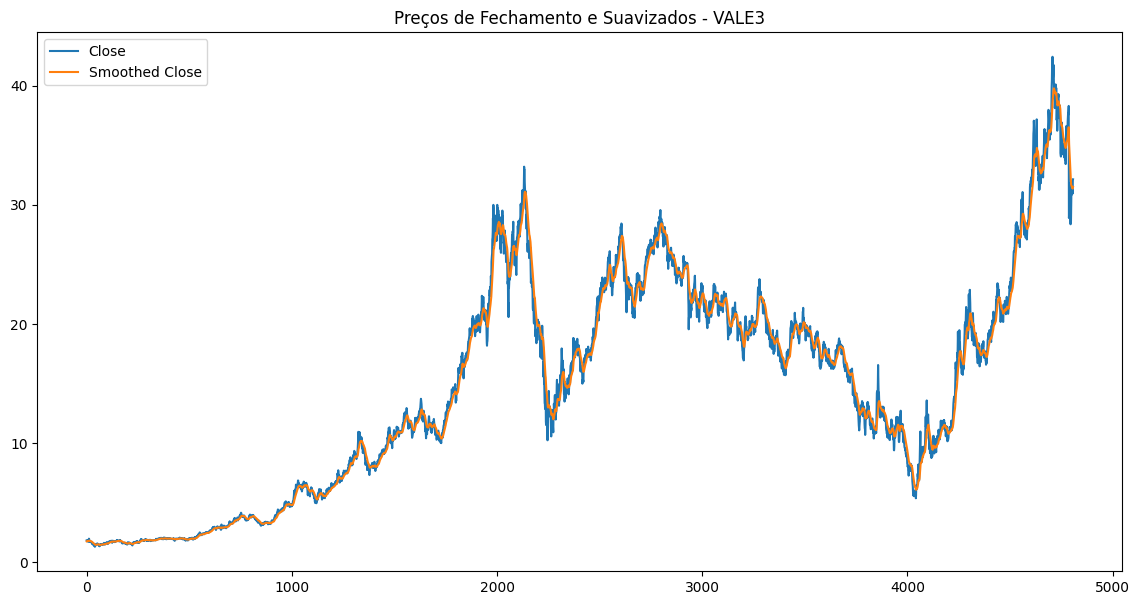

In [19]:
# COMPARAÇÃO ENTRE PREÇOS DE FECHAMENTO E PREÇOS DE FECHAMENTO SUAVIZADOS
plt.figure(figsize=(14, 7))
plt.plot(df_train['Close'], label='Close')
plt.plot(df_train['Smoothed_Close'], label='Smoothed Close')
plt.title(f'Preços de Fechamento e Suavizados - {nome_arquivo}')
plt.legend()
plt.show()

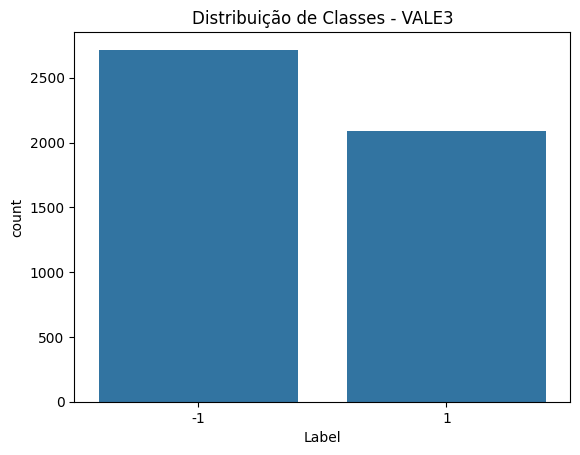

In [20]:
# DISTRIBUIÇÃO DOS RÓTULOS
sns.countplot(x='Label', data=df_train)
plt.title(f'Distribuição de Classes - {nome_arquivo}')
plt.show()

## Treinamento de modelo de Redes Neurais Recorrentes (RNN)

In [21]:
## NORMALIZAÇÃO DOS DADOS

# Normalizador para as features
scaler = StandardScaler()

# Função para converter rótulos em formato categórico
def converter_para_categorico(y):
    if y.min() == -1:  # Se os rótulos forem -1 e 1
        y = (y + 1) // 2  # Converter rótulos para 0 e 1
    return to_categorical(y)

X_train = df_train.drop(['Date', 'Close', 'Smoothed_Close', 'Label'], axis=1)
y_train = df_train['Label']

X_test = df_test.drop(['Date', 'Close', 'Smoothed_Close', 'Label'], axis=1)
y_test = df_test['Label']

# Normalizar as features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Converter os rótulos para formato categórico
y_train_cat = converter_para_categorico(y_train)
y_test_cat = converter_para_categorico(y_test)

In [26]:
# Cria e treina a rede LSTM
historicos = {}

model_rnn = Sequential([
        LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False, activation='relu'),
        Dense(y_train_cat.shape[1], activation='sigmoid')
    ])

# Compilando o modelo com entropia cruzada categórica para classificação binária
# A acurácia é usada como métrica para avaliação
model_rnn.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o modelo com os dados
# Epochs define o número de vezes que o modelo verá todo o conjunto de dados
# Batch size é o número de amostras que o modelo vê antes de atualizar os pesos
# Verbose=1 mostra a barra de progresso do treinamento

checkpointer = ModelCheckpoint(filepath='../models/melhor_rnn_vale3.keras', verbose=1,  save_best_only=True, monitor='val_accuracy')

historico_rnn = model_rnn.fit(X_train, y_train_cat, epochs=100, batch_size=8, validation_split=0.2, verbose=1, callbacks=[checkpointer],shuffle=True)


Epoch 1/100


/Users/cintia.duarte/Documents/develop/NEURAL-NETWORKS-REGRESSION/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


476/481 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5513 - loss: 0.6877
Epoch 1: val_accuracy improved from -inf to 0.56445, saving model to ../models/melhor_rnn_vale3.keras
481/481 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5514 - loss: 0.6877 - val_accuracy: 0.5644 - val_loss: 0.6843
Epoch 2/100
475/481 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5738 - loss: 0.6744
Epoch 2: val_accuracy did not improve from 0.56445
481/481 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5736 - loss: 0.6744 - val_accuracy: 0.5644 - val_loss: 0.6552
Epoch 3/100
475/481 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5700 - loss: 0.6502
Epoch 3: val_accuracy improved from 0.56445 to 0.67983, saving model to ../models/melhor_rnn_vale3.keras
481/481 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5705 - loss: 0.6500 - val_accuracy: 0.6798 - val_loss: 0.6054
Epoch 4/100
475/481 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6302 - loss: 0.6171
Epoch 4: val_accuracy improved from 0.67983 to 0.71933,

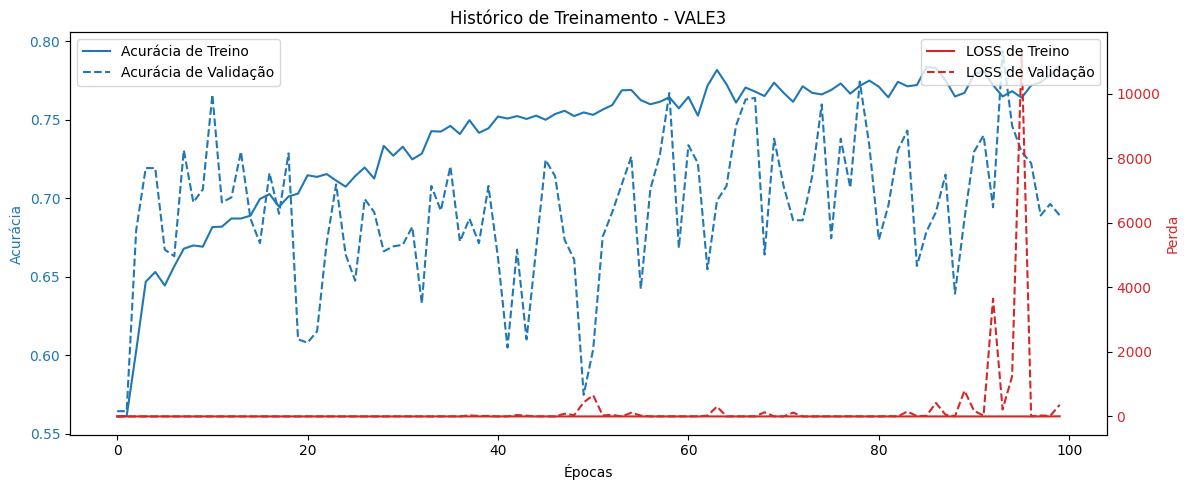

In [27]:
def plotar_historico(historico, titulo):
    fig, ax1 = plt.subplots(figsize=(12, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Acurácia', color=color)
    ax1.plot(historico.history['accuracy'], label='Acurácia de Treino', color=color)
    if 'val_accuracy' in historico.history:
        ax1.plot(historico.history['val_accuracy'], label='Acurácia de Validação', color=color, linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Perda', color=color)  # we already handled the x-label with ax1
    ax2.plot(historico.history['loss'], label='LOSS de Treino', color=color)
    if 'val_loss' in historico.history:
        ax2.plot(historico.history['val_loss'], label='LOSS de Validação', color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title(titulo)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()



plotar_historico(historico_rnn, f"Histórico de Treinamento - {nome_arquivo}")

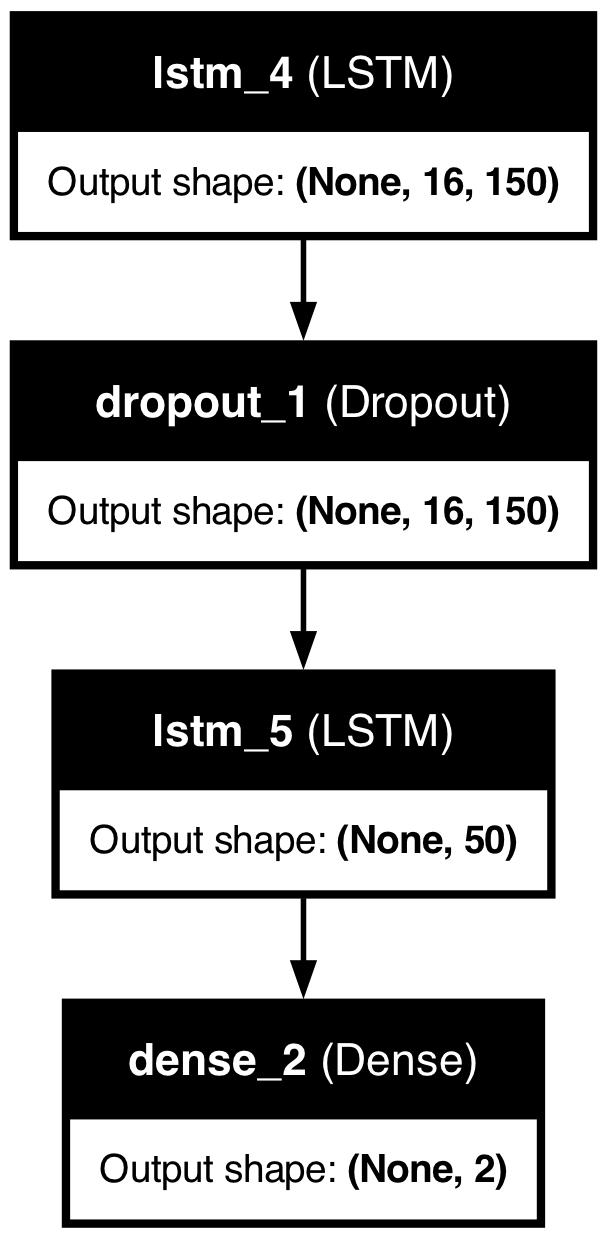

In [28]:
plot_model(model_rnn,show_shapes=True, show_layer_names=True)

VALE3 -> Acurácia: 56.36%
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Relatório de Classificação para VALE3:
               precision    recall  f1-score   support

           0       0.61      0.35      0.45       601
           1       0.55      0.77      0.64       602

    accuracy                           0.56      1203
   macro avg       0.58      0.56      0.54      1203
weighted avg       0.58      0.56      0.54      1203




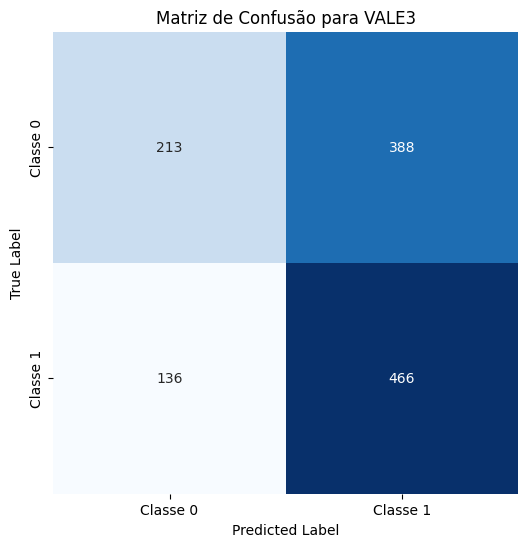

In [29]:
# Função para plotar a matriz de confusão
def plotar_matriz_confusao(cm, classes, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

# Avaliar o modelo
scores = model_rnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"{nome_arquivo} -> Acurácia: {scores[1]*100:.2f}%")

# Predições
y_pred = model_rnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_teste_classes = np.argmax(y_test_cat, axis=1)

# Gerar e plotar a matriz de confusão
cm = confusion_matrix(y_teste_classes, y_pred_classes)
plotar_matriz_confusao(cm, classes=['Classe 0', 'Classe 1'], title=f'Matriz de Confusão para {nome_arquivo}')

# Gerar relatório de classificação
print(f"Relatório de Classificação para {nome_arquivo}:\n {classification_report(y_teste_classes, y_pred_classes)}\n")